In [1]:
import pandas as np
import seaborn as sea 
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, dataframe
from pyspark.sql import functions as f

### Data & AI - PB Fast Learning - Ciência de Dados - 1/3

<div align="center">
    <img src='img/hierarquia.png' width="590px"/>
</div>

&nbsp;

Criando Seção no spark

In [2]:
spark = SparkSession.builder.master('local')\
    .appName('ProjetoSprint01')\
    .getOrCreate()
spark.sparkContext.setLogLevel("WARN")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/27 21:32:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/27 21:33:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
spark.sparkContext

<SparkContext master=local appName=ProjetoSprint01>

Carregando dados usando pyspark

In [4]:
# olist_customers_dataset
customers     = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_customers_dataset.csv')

# olist_geolocation_dataset
geolocation   = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_geolocation_dataset.csv')

# olist_order_payments_dataset
payments      = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_payments_dataset.csv')

# olist_orders_dataset
orders        = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_orders_dataset.csv')

# olist_order_items_dataset
order_items   = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_items_dataset.csv')

# olist_order_reviews_dataset
order_reviews = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_reviews_dataset.csv')

# olist_products_dataset
order_product = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_products_dataset.csv')

# olist_sellers_dataset
sellers      = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_sellers_dataset.csv')

# product_category_dataset
product_cat  = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/product_category_name_translation.csv')

Criando uma visão temporaria , pois usarei o sql do spark para fazer as questões

In [5]:
customers.createOrReplaceTempView('customers')
geolocation.createOrReplaceTempView('geolocation')
orders.createOrReplaceTempView('orders')
order_items.createOrReplaceTempView('order_items')
order_product.createOrReplaceTempView('order_product')
order_reviews.createOrReplaceTempView('order_reviews')
payments.createOrReplaceTempView('payments')
sellers.createOrReplaceTempView('sellers')
product_cat.createOrReplaceTempView('product_cat')

&nbsp;

## Analise

&nbsp;

### Quais são categorias com maior e menor receita dos ultimos 12 meses?

In [6]:
query = '''
select min(order_purchase_timestamp), max(order_purchase_timestamp)  from orders;
'''
spark.sql(query).toPandas()

,min(order_purchase_timestamp),max(order_purchase_timestamp)
0,2016-09-04 21:15:19,2018-10-17 17:30:18


> O data vão de 2016 a 2019

Usando Sql para fazer a questão

In [7]:
query = '''
SELECT product_category_name, SUM(payment_value) as Receita FROM order_items as o_i
    INNER JOIN order_product as o_p ON
        o_p.product_id = o_i.product_id
    INNER JOIN orders as or ON
        or.order_id = o_i.order_id
    INNER JOIN payments as pay ON
        pay.order_id = or.order_id

    WHERE order_status != 'canceled' and
        order_purchase_timestamp >= '2017-09-03 01:00:00' and
        order_purchase_timestamp <= '2018-09-03 09:06:57'
    GROUP BY product_category_name
    ORDER BY receita desc;
'''
# Transformando dataframe do spark em pandas dataframe para usar na visualização
data = spark.sql(query).toPandas()
data.head(3)

,product_category_name,Receita
0,beleza_saude,1327333.01
1,cama_mesa_banho,1311722.68
2,informatica_acessorios,1204670.90


Modificando a coluna `product_category_name` para torna-la mais legivel

In [8]:
# Tirar o `_` e colacando o ' '(espaco vazio) usando o replace
data['product_category_name'] = data['product_category_name'].str.replace('_',' ')
# Deixando as primeiras letras de cada palavra maiuscula
data['product_category_name'] = data['product_category_name'].str.title()

Usarei seaborn e matplotlib para visualização pois ele renderiza no github, diferente do plotly

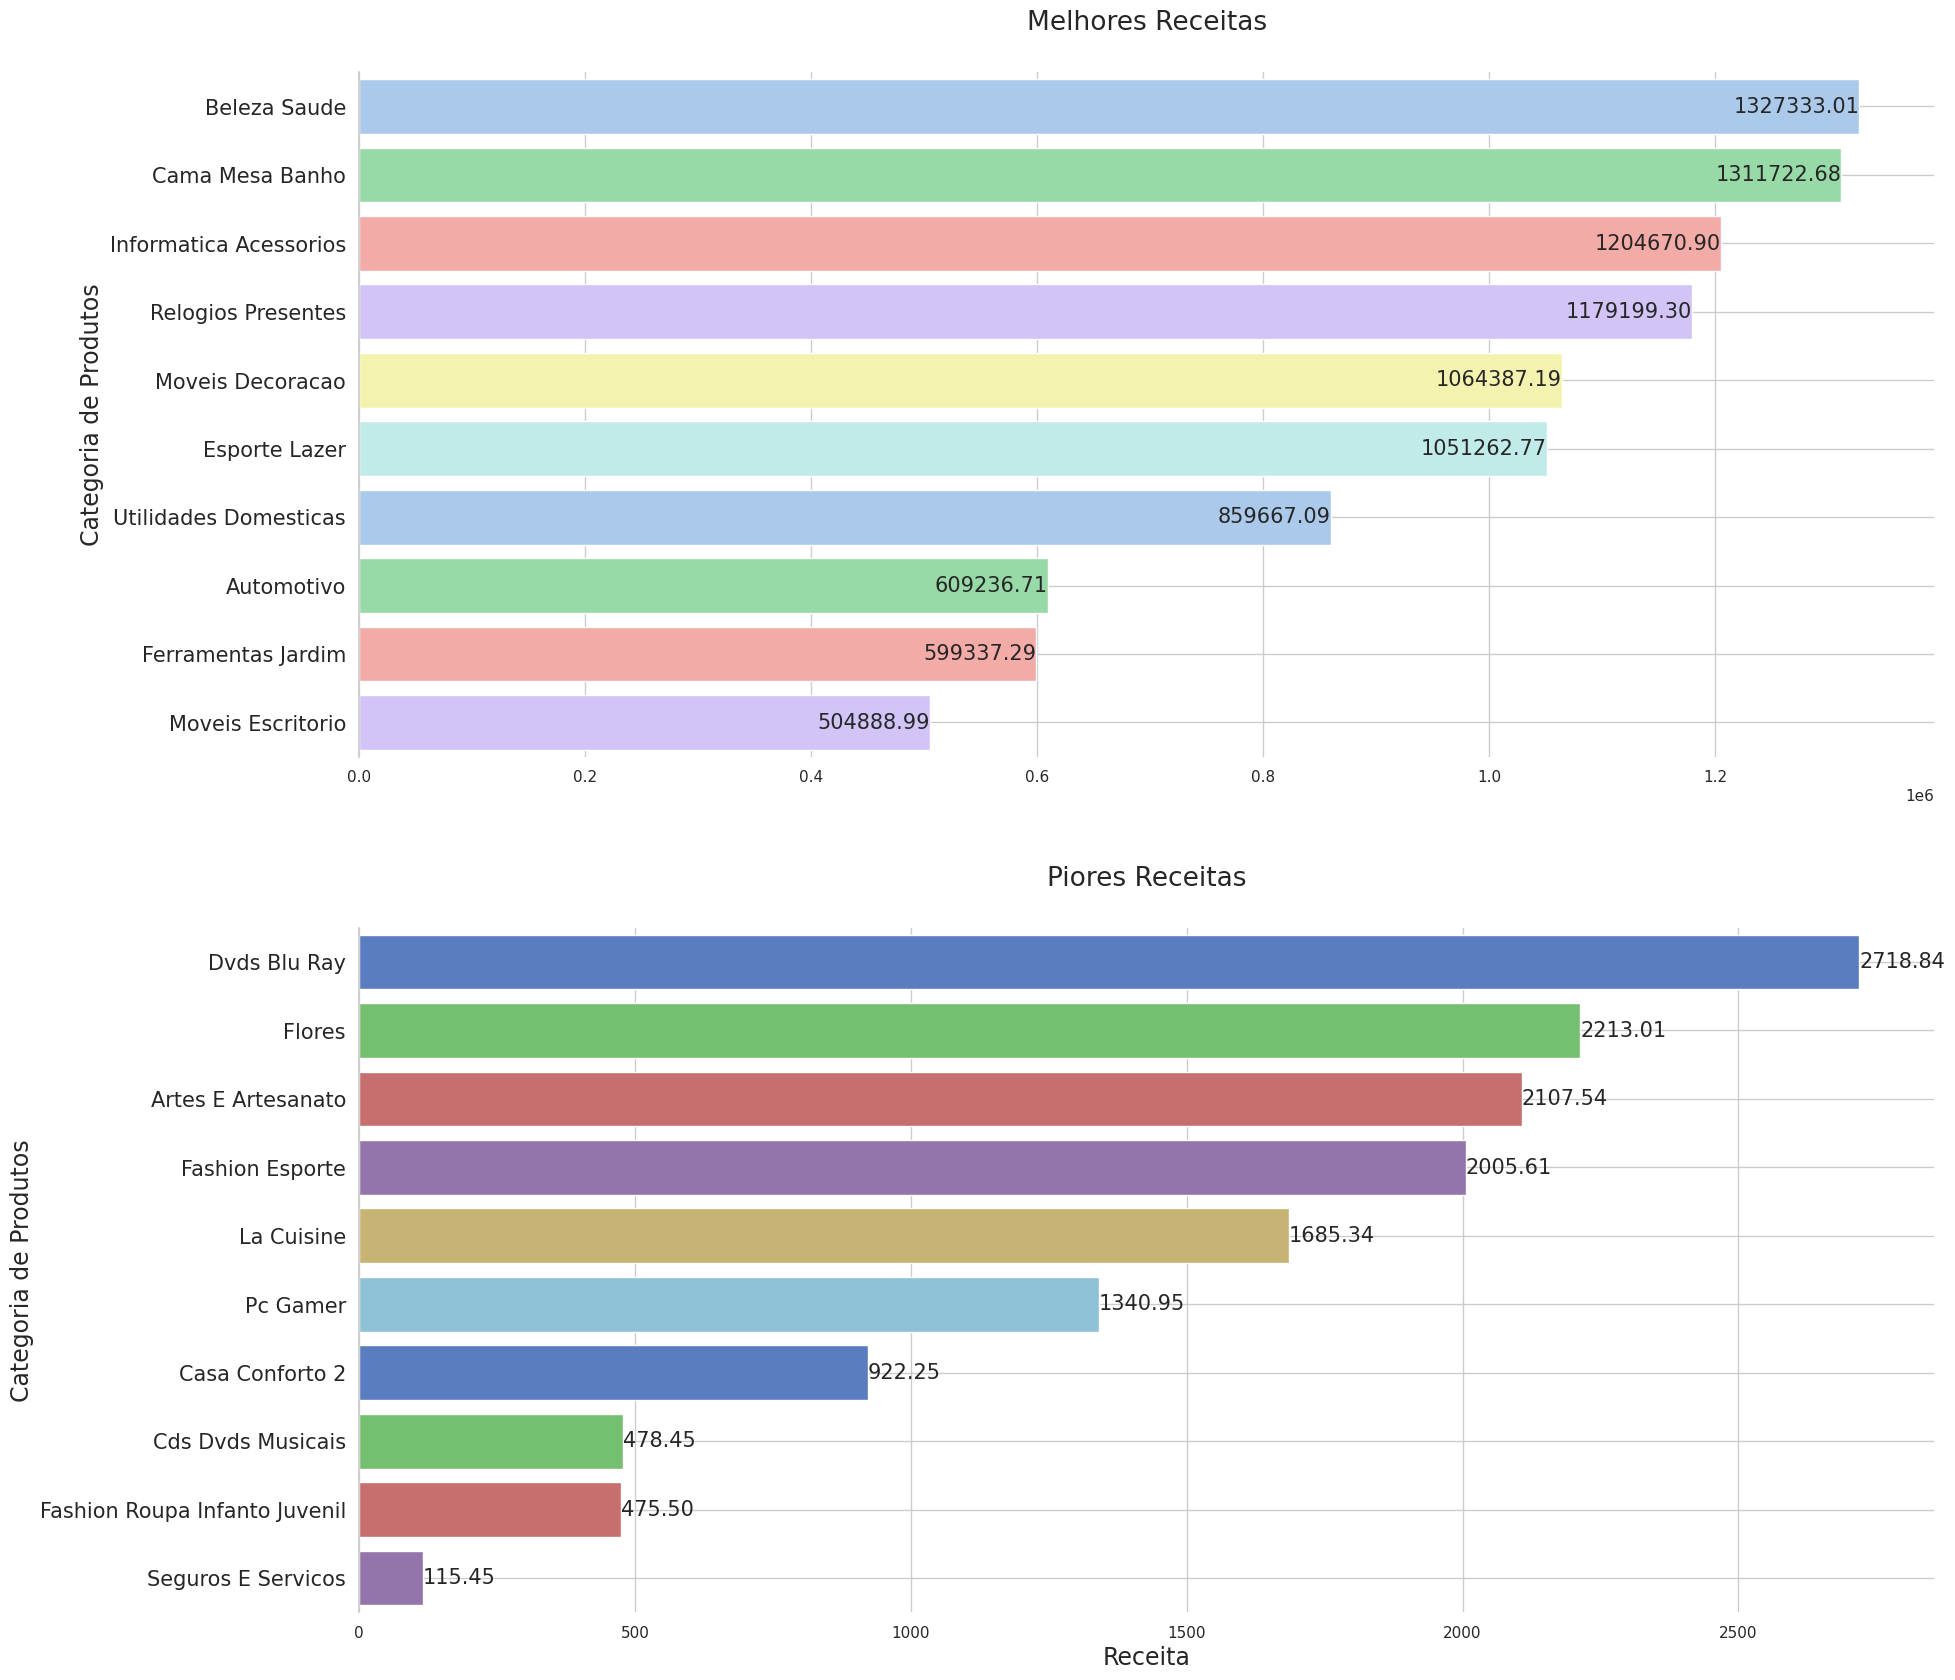

In [9]:
sea.set_theme(style="whitegrid")                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(18,20))
fig.subplots_adjust(hspace=0.25,right=1)        # Aumenta o espaço entre os graficos

# Grafico 1 = Melhores receitas
# Criando o grafico 1 com as melhores receitas
barMelhores = sea.barplot(
    data=data.iloc[0:10,:], 
    y ='product_category_name', x ='Receita', hue='product_category_name',
    palette = sea.color_palette('pastel6',n_colors=10), ax = ax[0], legend=False
)

#Modificando o Grafico 1
ax[0].set_title('Melhores Receitas',y=1.05,fontsize=19)
ax[0].set_ylabel('Categoria de Produtos',x=10,fontsize=17)
ax[0].set_xlabel('')
ax[0].spines[['right','top','bottom']].set_visible(False)
ax[0].tick_params('y', labelsize=15)
ax[0].set_axisbelow(True)
ax[0].grid(True)

# Colocando o valor das receitas nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("%.2f" % p.get_width()),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=15)

# Grafico 2 = Piores receitas
barPiores = sea.barplot(
    data=data.iloc[64:76,:], 
    y ='product_category_name', x ='Receita', hue='product_category_name',
    palette =  sea.color_palette('muted6',n_colors=10), ax = ax[1], legend=False
)
for p in barPiores.patches:
    if p.get_width() != 0:
        barPiores.annotate("%.2f" % p.get_width(),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'left', va = "center" ,size=15)

#Modificando o Grafico 2
ax[1].set_title('Piores Receitas',y=1.05,fontsize=19)       # Titulo 
ax[1].set_ylabel('Categoria de Produtos',x=10,fontsize=17)  # Modificando eixo y
ax[1].set_xlabel('Receita',fontsize=17)                     # Modificando eixo x
ax[1].spines[['right','top','bottom']].set_visible(False)   # Visibilidade das bordas
ax[1].tick_params('y', labelsize=15)                        # Fonte do eixo y
ax[1].set_axisbelow(True)
ax[1].grid(True) 

plt.show()

&nbsp;

### Top 10 maiores sellers (maior receita)?

In [11]:
query = '''
SELECT (INITCAP(se.seller_city)|| '-' || se.seller_state) as Seller ,
        ROUND(sum(payment_value),2) as receita FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id
    
    WHERE order_status != 'canceled'  
    GROUP BY seller
    ORDER BY receita desc limit 10; 
'''
spark.sql(query).show()

+--------------------+----------+
|              Seller|   receita|
+--------------------+----------+
|        Sao Paulo-SP|4219885.13|
|         Ibitinga-SP|1052073.49|
|         Curitiba-PR| 639494.11|
|  Itaquaquecetuba-SP| 573608.25|
|        Guarulhos-SP| 504891.99|
|   Rio De Janeiro-RJ| 491572.87|
|Sao Jose Do Rio P...| 414813.83|
|   Ribeirao Preto-SP| 393008.26|
|          Maringa-PR| 379812.94|
|       Piracicaba-SP| 355782.95|
+--------------------+----------+

